# System genetics assignment 2

### Setup

In [1]:
import os
import platform
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Read data sources

In [2]:
# Based on the platform choose the file locations
if platform.system() == 'Windows':
	# Rotem's file paths
	genotype_file_path = os.path.normpath('')
	phenotypes_file_path = os.path.normpath('')
else:
	# Carmi's file paths
	genotype_file_path = os.path.normpath('/Users/Shared/Data/system_genetics_data/genotypes.xls')
	phenotypes_file_path = os.path.normpath('/Users/Shared/Data/system_genetics_data/phenotypes.xls')
	

genotypes_df = pd.read_excel(genotype_file_path)
chosen_phenotype_df = pd.read_excel(phenotypes_file_path)

In the genotype table, B and D denote parental homozyges individuals and H denotes a heterozygos individual. U are unknows and will therefore be dropped when using their data

Import the Climbing scores after 16 mg/kg i.p. methamphetamine injection [quadrant crossings/min] phenotype from the phenotype table

In [3]:
chosen_phenotype_row = chosen_phenotype_df.loc[chosen_phenotype_df.ID_FOR_CHECK == 172]
# Remove the first 7 indexes since all the fields between 0 and 4 are metadata and 5 and 6 are mice we do not have in the phenotypes table
chosen_phenotype_row_data_homozygos = chosen_phenotype_row.iloc[:, 7:]

display(chosen_phenotype_row)

,ID_FOR_CHECK,Phenotype,Authors,Year,Pubmed Id,C57BL/6J,DBA/2J,BXD1,BXD2,BXD5,...,BXD94,BXD95,BXD96,BXD97,BXD98,BXD99,BXD100,BXD101,BXD102,BXD103
172,172,Climbing scores after 16 mg/kg i.p. methamphet...,"Grisel JE, Belknap JK, O'Toole LA, Helms ML, W...",1997,8987796.0,2.3,0.6,0.1,-0.8,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def get_genotype_phenotype_df(all_snps_df, chosen_phenotype_df, is_include_heterozygos_genotypes=False):
	'''
	Description
	-----------
	Make a dataframe with snps as their original letter, the numaric represantation of them and the phenotype value.
	The function will always drop "U" - unknown genotypes and if is_include_geterozygos_genotypes=True it will incluse hetezygos (H) individuals as well.
	This function does not change the state of the provided dataframes.

	Parameters
	----------
	all_snps_df : pandas dataframe
		The dataframe containing the individuals and thier genotype as a single letter.
		D and B are homozygos parental genotypes, H is geterozygos and U is unknown.
	chosen_phenotype_df : pandas dataframe
		The dataframe containing the individuals and thier phenotype measurement as a float from the chosen phenotype row (only a single row is expected).
	is_include_heterozygos_genotypes : bool
		if set to True, then heterozygos individuals will be included in the returned matrix

	Returns
	-------
	genotype_phenotype_df : pandas dataframe
		Fields:
			individual : str
				The individual BXD id (ex BXD1)
			snp_locus : str,
				The snp locus indentifier (ex rs6269442)
			snp_chr : int,
				the snp chromosome (1, 2...)
			genotype_letter : str,
				B and D denote parental homozyges individuals and H denotes a heterozygos individual
			genotype_num : int,
				The genotype_letter converted to a number, B=0, H=1, D=2
			phenotype_value : float
				The value of the phenotype to associate as a float
	'''
	chosen_phenotype_df_data = chosen_phenotype_df.copy()
	# Remove the first 7 indexes since all the fields between 0 and 4 are metadata and 5 and 6 are mice we do not have in the phenotypes table
	chosen_phenotype_df_data = chosen_phenotype_df_data.iloc[:, 7:]
	# As a first step, remove columns from the phenotypes df that have NaN in them.
	# Since we are expecting a single row then this is OK and won't destroy data for other associations.
	chosen_phenotype_df_data = chosen_phenotype_df_data.dropna(axis=1, how='any')

	# Now remove all genotypes for which we do not have a phenotypic measurement
	snps_df = all_snps_df.copy()
	# Split to data and metadata for ease of work
	snps_df_metadata = snps_df.iloc[:, :4]
	snps_df_data = snps_df.iloc[:, 4:]
	# For some reasson there are 'b' values in the file convert them to 'B'
	snps_df_data = snps_df_data.replace('b', 'B')

	# Get the columns to keep
	common_columns = snps_df_data.columns.intersection(chosen_phenotype_df_data.columns)
	snps_df_data = snps_df_data.loc[:, common_columns]
	# Put all the data back into the original dataframe
	snps_df = pd.concat([snps_df_metadata, snps_df_data], axis=1)

	# As the last step of data cleaning set the letters to drop.
	# U is always dropped, and if we aren't keeping heterozygos individuals then remove H as well.
	letters_to_drop = ['U']
	if is_include_heterozygos_genotypes:
		letters_to_drop.append('H')

	snps_df = snps_df.replace(letters_to_drop, pd.NA)

	# Prepare all columns to be saved into a flattened df
	individuals_column = np.tile(snps_df_data.columns, snps_df_data.shape[0])
	locus_column = np.tile(snps_df['Locus'].values.flatten(), snps_df_data.shape[1])
	chr_column = np.tile(snps_df['Chr_Build37'].values.flatten(), snps_df_data.shape[1])
	binary_rep = [ 0 if value == 'B' else (1 if value == 'H' else 2) for value in snps_df_data.values.flatten()]
	phenotypes_column = np.tile(chosen_phenotype_df_data, snps_df_data.shape[0])[0]
	
	
	# Create the final dataframe
	genotype_phenotype_df = pd.DataFrame({
		'individual' : individuals_column,
		'locus' : locus_column,
		'chr' : chr_column,
		'genotype_num' : binary_rep,
		'phenotype_value' : phenotypes_column
	})

	# Since the letter are across many fields it's easier to fill the column this way as opposed to what was done above
	genotype_phenotype_df['genotype_letter'] = genotype_phenotype_df['genotype_num'].apply(lambda x: 'B' if x == 0 else ('H' if x == 1 else 'D'))

	# Move 'phenotype_value' column to the end
	columns = [col for col in genotype_phenotype_df.columns if col != 'phenotype_value'] + ['phenotype_value']
	genotype_phenotype_df = genotype_phenotype_df[columns]


	return genotype_phenotype_df

In [5]:
def statsmodels_linear_regression(X, y, is_heterozygos_included=False):
	'''
	TODO: Document this
	'''
	# Use statmodels to perform the regression analysis
	genotype_numbers_for_sm = sm.add_constant(X)
	reg_model = sm.OLS(y, genotype_numbers_for_sm)
	results = reg_model.fit()

	# Plot the data and the regression line
	fig, ax = plt.subplots(figsize=(8, 8))
	ax.scatter(X, y)
	if is_heterozygos_included:
		ax.set_xlabel('Locus base (B=0, H=1, D=2)')
	else:
		ax.set_xlabel('Locus base (B=0, D=2)')
	ax.set_ylabel('Climbing scores after 16 mg/kg i.p. \nmethamphetamine injection [quadrant crossings/min]')

	ax.axline((0, results.params[1]), slope=results.rsquared, color='black' ,label=f'fitted regression line, y={results.rsquared:.2f}X + {results.params[1]},\n p value = {results.pvalues[0]:.2f}')

	plt.legend()
	plt.show()

## Question 1

### Find a locus with hetroziygosity

In [6]:
# Save the locus index found for later use
locus_index = -1
locus_id = ''

for index, row in genotypes_df.iterrows():
	# Exclude the first three columns (Locus, Chr_Build3, Build37_pc)
	alleles = row[3:]
	if 'B' in alleles.values and 'D' in alleles.values and 'H' in alleles.values:
		print(f"SNP {row['Locus']} at row {index} has heterozygosity.")
		locus_index = index
		locus_id = row['Locus']
		break 

SNP rs6269442 at row 0 has heterozygosity.


In [7]:
genotype_phenotype_df = get_genotype_phenotype_df(genotypes_df, chosen_phenotype_row, is_include_heterozygos_genotypes=True)
display(genotype_phenotype_df)

,individual,locus,chr,genotype_num,genotype_letter,phenotype_value
0,BXD1,rs6269442,1,0,B,0.1
1,BXD2,rs6365999,1,0,B,-0.8
2,BXD5,rs6376963,1,2,D,1.5
3,BXD6,rs3677817,1,2,D,-0.8
4,BXD8,rs8236463,1,2,D,0.3
...,...,...,...,...,...,...
91099,BXD28,CEL-X_154259201,20,0,B,1.0
91100,BXD29,rs3657281,20,0,B,-1.4
91101,BXD30,rs13484106,20,2,D,2.6
91102,BXD31,gnfX.146.867,20,0,B,-0.8


In [8]:
def statsmodels_linear_regression(X, y, is_heterozygos_included=False):
	'''
	TODO: Document this
	'''
	# Use statmodels to perform the regression analysis
	genotype_numbers_for_sm = sm.add_constant(X)
	reg_model = sm.OLS(y, genotype_numbers_for_sm)
	results = reg_model.fit()

	# Plot the data and the regression line
	fig, ax = plt.subplots(figsize=(8, 8))
	ax.scatter(X, y)
	if is_heterozygos_included:
		ax.set_xlabel('Locus base (B=0, H=1, D=2)')
	else:
		ax.set_xlabel('Locus base (B=0, D=2)')
	ax.set_ylabel('Climbing scores after 16 mg/kg i.p. \nmethamphetamine injection [quadrant crossings/min]')

	ax.axline((0, results.params[1]), slope=results.rsquared, color='black' ,label=f'fitted regression line, y={results.rsquared:.2f}X + {results.params[1]:.2f},\n p value = {results.pvalues[0]:.2f}')

	plt.legend()
	plt.show()

### (a) linear regression model in which heterozygous markers are ignored

In [9]:
chosen_snp_df = genotype_phenotype_df.loc[genotype_phenotype_df['locus'] == locus_id]
chosen_snp_df_no_heterozygots = chosen_snp_df[chosen_snp_df['genotype_letter'] != 'H']
display(chosen_snp_df_no_heterozygots)

,individual,locus,chr,genotype_num,genotype_letter,phenotype_value
0,BXD1,rs6269442,1,0,B,0.1
3796,BXD8,rs6269442,1,0,B,0.3
7592,BXD14,rs6269442,1,2,D,-1.0
11388,BXD19,rs6269442,1,2,D,0.4
15184,BXD24,rs6269442,1,0,B,0.8
18980,BXD29,rs6269442,1,0,B,-1.4
22776,BXD1,rs6269442,1,2,D,0.1
26572,BXD8,rs6269442,1,0,B,0.3
30368,BXD14,rs6269442,1,2,D,-1.0
34164,BXD19,rs6269442,1,2,D,0.4


In [10]:
# TODO carmi: Finish this later and get it working. Compare with statsmodels result for the same
def linear_regression(X, y, m = 0, b = 0, learning_rate = 0.001, epochs = 100):
	'''
	Description
	-----------
	Perform a linear regression using gradient descent on the data points provided in X and y

	Parameters
	----------
	m : float
		The initial value from which the gradient descent will start for m
	b : float
		The initial value from which the gradient descent will start for b
	X : np array
		The X values for the observations to regress on
	y : np array
		The y values for the observations to regress to
	learning_rate : float
		An attenuating controling the pace of the gradient descent
	epochs : int
		The number of steps to calculate in the gradient descent
		
	Returns
	-------
	(m , b, r_squared, p_value) of the optimal regression line found at the the of the specified number of epochs
	'''

	n = len(X)

	for _ in range(epochs):
		y_pred = m * X + b

		# Partial derivitaves as calculated in class
		m_gradient = (-2/n) * sum(X * (y - y_pred))
		b_gradient = (-2/n) * sum(y - y_pred)

		m = m - learning_rate * m_gradient
		b = b - learning_rate * b_gradient



	return (m, b, 0, 0)


print(linear_regression(chosen_snp_df_no_heterozygots['genotype_num'], chosen_snp_df_no_heterozygots['phenotype_value']))

(-0.04459407843785901, -0.01891843452799466, 0, 0)


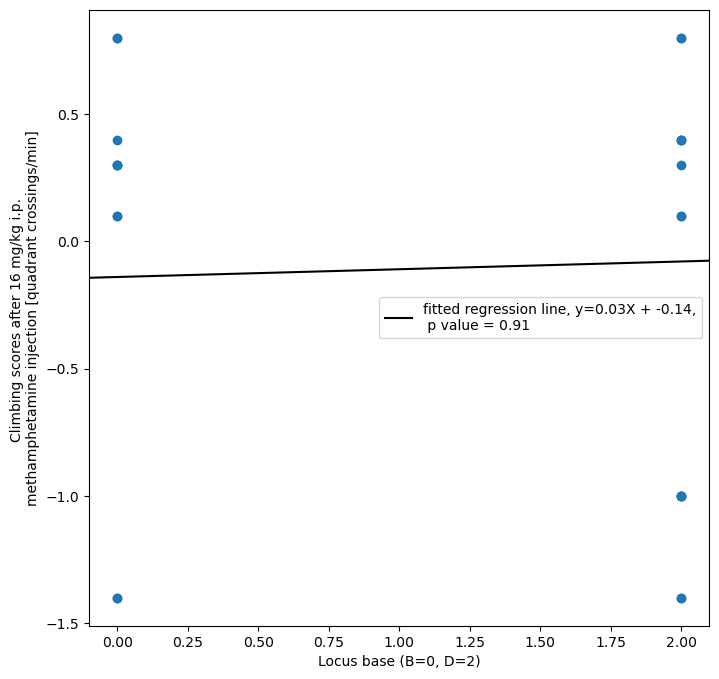

In [11]:
statsmodels_linear_regression(np.array(chosen_snp_df_no_heterozygots['genotype_num']), np.array(chosen_snp_df_no_heterozygots['phenotype_value']))

### (b) linear regression model in which heterozygous markers are considered

Since the locus we chose in (a) has no heterozygos individuals after cleanup, in this subsection I'll write code to search for a SNP that has H and a phenotypic measurement associated with it

In [12]:
h_containig_locus_id = genotype_phenotype_df.loc[genotype_phenotype_df.genotype_letter == 'H'].iloc[0].locus
# Grab the data based on the locus id
h_containig_locus_data = genotype_phenotype_df.loc[genotype_phenotype_df['locus'] == h_containig_locus_id]

/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_51251/2483923818.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axline((0, results.params[1]), slope=results.rsquared, color='black' ,label=f'fitted regression line, y={results.rsquared:.2f}X + {results.params[1]:.2f},\n p value = {results.pvalues[0]:.2f}')
/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_51251/2483923818.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axline((0, results.params[1]), slope=results.rsquared, color='black' ,label=f'fitted regression line, y={results.rsquared:.2f}X + {results.params[1]:.2f},\n p value =

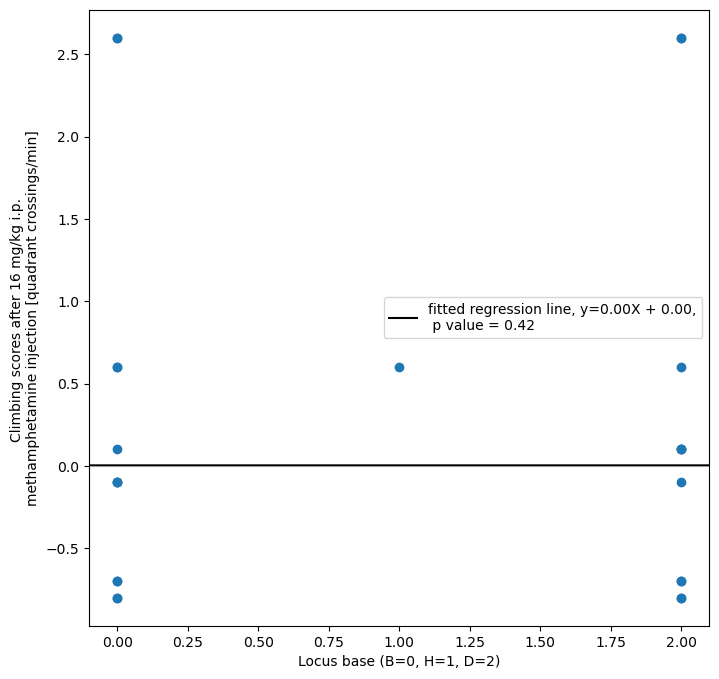

In [13]:
# Check the linear regression result
statsmodels_linear_regression(h_containig_locus_data['genotype_num'], h_containig_locus_data['phenotype_value'], is_heterozygos_included=True)